In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
from pathlib import Path
import sys
import yaml
import matplotlib.pyplot as plt
sys.path.append("../../")

In [4]:
from pytorch_toolbox.pipeline import Pipeline, load_config_from_path
from pytorch_toolbox.utils.vision import tensor2img
from src.training.train_with_template import lookups
from src.training.image import plot_rgby

#### Load the configuration file needed to construct the DAG for the pipeline

In [5]:
CONFIG_FILE_PATH = Path("../configs/se_resnext50_config.yml")
CONFIG_FILE_PATH = Path("../configs/densenet121.yml")

In [6]:
config = load_config_from_path(CONFIG_FILE_PATH, with_variable_replacement=True)

In [7]:
pipeline = Pipeline.create_from_config(config, lookups)

In [8]:
pipeline.sorted_node_names

['CheckIfRunInferenceModelSavePath',
 'CreateInferenceModelSavePath',
 'CreateResultRecorder',
 'CreateTimeStampedSavePath',
 'RunRecordResults',
 'SaveConfiguration',
 'CreateTensorBoardRecorderLearnerCallback',
 'CreateCSVLoggerLearnerCallback',
 'CreateSaveModelCallback',
 'CreateFiveCropTTAPredictionCallback',
 'CreateGradientClippingLearnerCallback',
 'CreateLabelExtractorCallback',
 'CreateCallbacksForInference',
 'CreateCallbacks',
 'CreateLovaszHingeFlatLoss',
 'CreateSoftF1Loss',
 'CreateFocalLoss',
 'CreateFocalLossMetric',
 'CreateF1SoftMetric',
 'CreateAccuracyMetric',
 'CreateModel',
 'CreateLearnerForInference',
 'CreateTrainingScheme',
 'CreateDenormalizeFunction',
 'CreateOutputRecorderLearnerCallback',
 'CreateLearnerCallbacks',
 'CreateLearner',
 'CreateNormalizeFunction',
 'CreateFiveCropTTAFunction',
 'CreateTestAugmentationFunction',
 'CreateAugmentationFunction',
 'CreateOpenImageFunction',
 'CreateTestingDataset',
 'CreateDataBunchForInference',
 'CreateInference

#### Get the nodes needed to create the learner

In [9]:
pipeline.run(to_node="CreateDataBunch")

In [10]:
split_idxs = pipeline.get_node_output("CreateSplitIndices")
create_data_bunch = pipeline.get_node_output("CreateDataBunch")
create_learner = pipeline.get_node_output("CreateLearner")
normalization_function = pipeline.get_node_output("CreateNormalizeFunction")
denormalization_function = pipeline.get_node_output("CreateDenormalizeFunction")

In [11]:
train_idx, val_idx = next(split_idxs)

In [12]:
data_bunch = create_data_bunch(train_idx, val_idx)

#### Uncomment below to see the output of the data loader

In [13]:
# train_image_batch, _ = next(iter(data_bunch.train_dl))
# train_image = train_image_batch[0]
# plot_rgby(tensor2img(train_image, denormalize_fn=denormalization_function, scale_factor=1.0))

In [14]:
# five_crop_images, _ = next(iter(data_bunch.valid_dl))
# five_crop_image = five_crop_images[0]
# for crop in five_crop_image:
#     plot_rgby(tensor2img(crop, denormalize_fn=denormalization_function, scale_factor=1.0))

#### Find the optimal learning rate

In [15]:
N_ITERS = 500

In [16]:
learner = create_learner(data_bunch)
learner.lr_find(num_it=N_ITERS)
learner.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


TypeError: '<' not supported between instances of 'NoneType' and 'float'

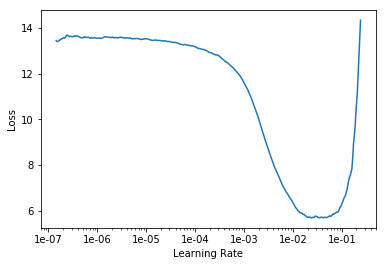

In [17]:
learner.recorder.plot()

In [ ]:
for lr, loss in zip(learner.recorder.lrs[10:-5], learner.recorder.losses[10:-5]):
    print(lr, loss)